In [1]:
#importing packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import geopandas as gpd #having some dificulty with geopandas, have tried a number of different versions,
#appears pyproj is the issue

Data imported from Github repo, also available at the following source as provide by DrivenData on behalf of Taarifa (Tanzania Ministry of Water)

Data Source <https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/data/>

Data inlcudes a set of training data with labels and a set of test data for prediction and submission

In [2]:
values = pd.read_csv('Source_data/trainset_values.csv')

Taking a look at the data below gives us a feel for what has been provided

In [3]:
values.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
values.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 40 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55765 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59400 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

We see that ther are some null values in columns 
['funder', 'installer', 'subvillage', 'public_meeting', 'scheme_management', 'scheme_name', 'permit']
that will need to be handled. It also appears that some columns provide overlapping information (extraction, management, payment, water quality and quantity, source and waterpoint). We will have to investiagte further if each column provides enough new information to keep. 

In [5]:
labels = pd.read_csv('Source_data/trainset_labels.csv')

Taking a look at the training labels below we see that there are 3 groups: functional, non functional and 

In [6]:
labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


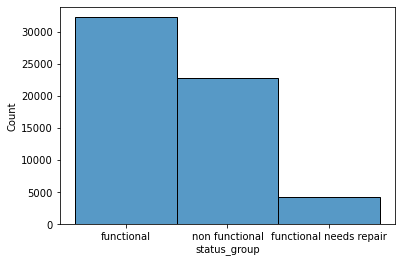

In [7]:
sns.histplot(data=labels, x='status_group')
plt.show()

In [8]:
values.columns

Index(['id', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'source_type', 'source_class', 'waterpoint_type',
       'waterpoint_type_group'],
      dtype='object')

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- num_private -
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

We can add the labels onto the values dataframe in order to do some further EDA

In [9]:
values.insert(loc=1, column='label', value=labels['status_group'])

In [10]:
values.head()

,id,label,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


Let's take a look at some details of the source columns ['source', 'source_type', 'source_class']

In [11]:
values['source'].value_counts(), values['source_type'].value_counts(), values['source_class'].value_counts()

(spring                  17021
 shallow well            16824
 machine dbh             11075
 river                    9612
 rainwater harvesting     2295
 hand dtw                  874
 lake                      765
 dam                       656
 other                     212
 unknown                    66
 Name: source, dtype: int64,
 spring                  17021
 shallow well            16824
 borehole                11949
 river/lake              10377
 rainwater harvesting     2295
 dam                       656
 other                     278
 Name: source_type, dtype: int64,
 groundwater    45794
 surface        13328
 unknown          278
 Name: source_class, dtype: int64)

'source' and 'source_type' have very little difference expect:
- 'river' and 'lake' categories combined to 'river/lake'
- 'other' and 'unknown' combined into a single category called 'other'
- 'machine dbw' and 'hand dtw' were combined into a single 'borehole' category

In [12]:
#Let's take a look at the distribution of the labels overall
labelcount = values.groupby('label')['id'].count()
labelcount = pd.concat([labelcount, values.groupby('label')['id'].apply(lambda x:'{0:.1f}%'.format(x.count()/len(values['id'])*100))], axis=1)
labelcount.columns = ['count', 'percent']
labelcount

,count,percent
label,,
functional,32259,54.3%
functional needs repair,4317,7.3%
non functional,22824,38.4%


We can then compare this distrubtion against the distribution with each source type. If the value for the different sources are consistent with the average then it would mean we aren't necessary gather more data from having the most robust amount of columns. However, if there are differences then we would want to keep those differences intact for our model. We are looking to choose which of the source columns to use in order to limit colinearity in our data, though we could add this information back in at a later time if we think it could increase our model perfomance.

In [13]:
#Reviewing counts of labels per each source
sourcecount = values.groupby(['label', 'source'])['id'].count().unstack()
sourcecount

source,dam,hand dtw,lake,machine dbh,other,rainwater harvesting,river,shallow well,spring,unknown
label,,,,,,,,,,
functional,253,497,162,5422,126,1386,5465,8324,10592,32
functional needs repair,24,17,12,491,1,314,1221,957,1276,4
non functional,379,360,591,5162,85,595,2926,7543,5153,30


In [14]:
#USing our counts to determine percentges for simpler comparison against the total percentages found above
sourceper = sourcecount/sourcecount.sum()*100
sourceper

source,dam,hand dtw,lake,machine dbh,other,rainwater harvesting,river,shallow well,spring,unknown
label,,,,,,,,,,
functional,38.567073,56.864989,21.176471,48.957111,59.433962,60.392157,56.856013,49.476938,62.229011,48.484848
functional needs repair,3.658537,1.945080,1.568627,4.433409,0.471698,13.681917,12.702871,5.688302,7.496622,6.060606
non functional,57.774390,41.189931,77.254902,46.609481,40.094340,25.925926,30.441115,44.834760,30.274367,45.454545


The overall data had values of:
- functional 54.3%
- functional needs repair 7.3% 
- non functional 38.4%

Source categories hand dtw, other, river, shallow well, unknown

Source categories dam, lake, machine dbh, rainwater harvesting, and spring deviate from the overall numbers in varying ways. For example, dam had nearly a reversal of the percentages for functional and non functional making it a strong feature for recognizing non functional well points. Also while rainwater harvesting has a slightly higher to overall percent functional, it also has double the functional needs repair of the overall and will be a good indicator for the that category. We will keep the 'source' column and drop 'source_type' and 'source_class'.

In [15]:
data = values.drop(columns=['source_type', 'source_class'])
data.columns

Index(['id', 'label', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region', 'region_code', 'district_code', 'lga',
       'ward', 'population', 'public_meeting', 'recorded_by',
       'scheme_management', 'scheme_name', 'permit', 'construction_year',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

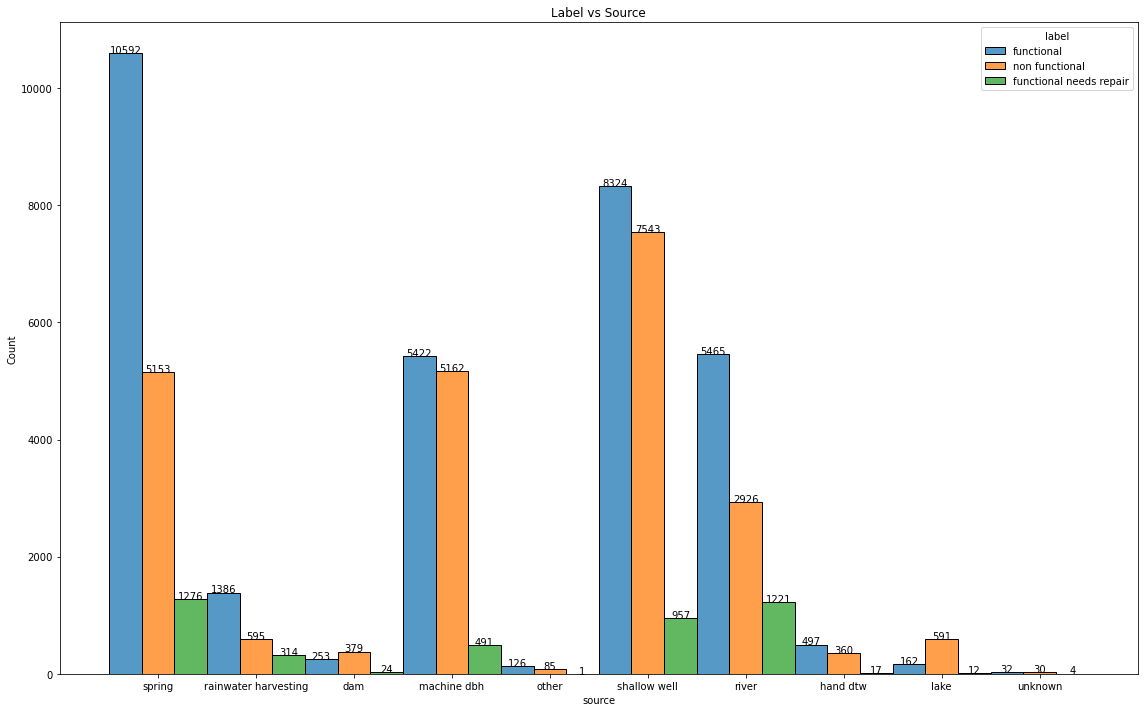

In [16]:
#plotting source and label comparisons
plt.figure(figsize=(16, 10))
ax=sns.histplot(data=values, x='source', hue='label', multiple='dodge')
total = len(values['label'])
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2), y=height+0., s=height, ha='center')
plt.title('Label vs Source')
plt.tight_layout()
plt.show()

We will look at the other features that have multiple columns. For now we are looking to keep only one of each column to limit collinearity, though we can come back later if we feel they have value to add. 

In [17]:
values['extraction_type'].value_counts(), values['extraction_type_group'].value_counts(), values['extraction_type_class'].value_counts()

(gravity                      26780
 nira/tanira                   8154
 other                         6430
 submersible                   4764
 swn 80                        3670
 mono                          2865
 india mark ii                 2400
 afridev                       1770
 ksb                           1415
 other - rope pump              451
 other - swn 81                 229
 windmill                       117
 india mark iii                  98
 cemo                            90
 other - play pump               85
 walimi                          48
 climax                          32
 other - mkulima/shinyanga        2
 Name: extraction_type, dtype: int64,
 gravity            26780
 nira/tanira         8154
 other               6430
 submersible         6179
 swn 80              3670
 mono                2865
 india mark ii       2400
 afridev             1770
 rope pump            451
 other handpump       364
 other motorpump      122
 wind-powered         117
 i

In [18]:
#Reviewing counts of labels per each extraction_type
excount = values.groupby(['label', 'extraction_type'])['id'].count().unstack()
excount

extraction_type,afridev,cemo,climax,gravity,india mark ii,india mark iii,ksb,mono,nira/tanira,other,other - mkulima/shinyanga,other - play pump,other - rope pump,other - swn 81,submersible,swn 80,walimi,windmill
label,,,,,,,,,,,,,,,,,,
functional,1200.0,45.0,8.0,16048.0,1448.0,44.0,703.0,1082.0,5421.0,1029.0,NaN,29.0,293.0,120.0,2626.0,2090.0,23.0,50.0
functional needs repair,42.0,9.0,NaN,2701.0,79.0,1.0,26.0,129.0,641.0,206.0,NaN,1.0,17.0,7.0,227.0,212.0,12.0,7.0
non functional,528.0,36.0,24.0,8031.0,873.0,53.0,686.0,1654.0,2092.0,5195.0,2.0,55.0,141.0,102.0,1911.0,1368.0,13.0,60.0


In [19]:
#Using our counts to determine percentges for simpler comparison against the total percentages found above
exper = excount/excount.sum()*100
exper

extraction_type,afridev,cemo,climax,gravity,india mark ii,india mark iii,ksb,mono,nira/tanira,other,other - mkulima/shinyanga,other - play pump,other - rope pump,other - swn 81,submersible,swn 80,walimi,windmill
label,,,,,,,,,,,,,,,,,,
functional,67.796610,50.0,25.0,59.925317,60.333333,44.897959,49.681979,37.766143,66.482708,16.003110,NaN,34.117647,64.966741,52.401747,55.121746,56.948229,47.916667,42.735043
functional needs repair,2.372881,10.0,NaN,10.085885,3.291667,1.020408,1.837456,4.502618,7.861172,3.203733,NaN,1.176471,3.769401,3.056769,4.764903,5.776567,25.000000,5.982906
non functional,29.830508,40.0,75.0,29.988798,36.375000,54.081633,48.480565,57.731239,25.656120,80.793157,100.0,64.705882,31.263858,44.541485,40.113350,37.275204,27.083333,51.282051


The overall data had values of:
- functional 54.3%
- functional needs repair 7.3% 
- non functional 38.4%

Most categories seem to deviate from the norm so we want to keep ans many as possible, however some have relatively small data asscoaited with them, i.e. other-mkulima/shinyanga. For that reason we are going to use the intermediate break down with the exception of keeping ksb and submersible seperate as well as cemo and climax seperate. These categories that are merged under the extraction_type_group column seem to have enough value to keep seperate. We will keep the extraction_type column, but map other swn 81, other-play pump, walimi and other-mkulima/shinyanga together into a single other-handpump group

In [20]:
data = data.drop(columns=['extraction_type_group', 'extraction_type_class'])
data['extraction_type'].replace({'other - swn 81':'other-handpump',
                                 'other - play pump':'other-handpump', 
                                 'walimi':'other-handpump', 
                                 'other - mkulima/shinyanga':'other-handpump',
                                'swn 80':'swn_80',
                                 'nira/tanira':'nira-tanira',
                                'india mark ii':'india_mark_ii',
                                'india mark iii':'india_mark_iii',
                                'other - rope pump':'other-rope_pump',}, inplace=True)
data['extraction_type'].unique()

array(['gravity', 'submersible', 'swn_80', 'nira-tanira', 'india_mark_ii',
       'other', 'ksb', 'mono', 'windmill', 'afridev', 'other-rope_pump',
       'india_mark_iii', 'other-handpump', 'cemo', 'climax'], dtype=object)

We should also clean up some of the source names before we go further to eliminate erroneous spaces and symbols.

In [21]:
data['source'].replace({'shallow well':'shallow_well',
                       'machine dbh':'machine_dbh',
                       'rainwater harvesting':'rainwater_harvesting',
                       'hand dtw':'hand_dtw'}, inplace=True)
data['source'].unique()

array(['spring', 'rainwater_harvesting', 'dam', 'machine_dbh', 'other',
       'shallow_well', 'river', 'hand_dtw', 'lake', 'unknown'],
      dtype=object)

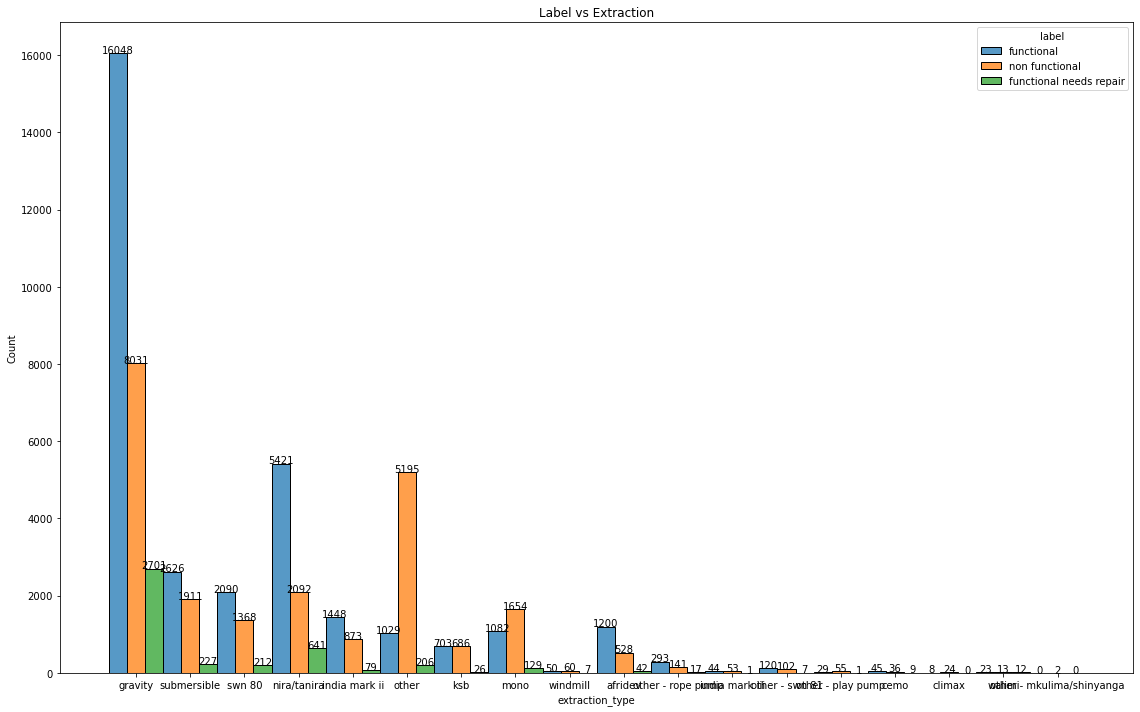

In [22]:
#plotting extraction_type and label comparisons
plt.figure(figsize=(16, 10))
ax=sns.histplot(data=values, x='extraction_type', hue='label', multiple='dodge')
total = len(values['label'])
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2), y=height+0., s=height, ha='center')
plt.title('Label vs Extraction')
plt.tight_layout()
plt.show()

Now lets take a look at some of the location columns

In [23]:
#
data[['region', 'region_code', 'subvillage']].nunique()

region            21
region_code       27
subvillage     19287
dtype: int64

There are over 19k subvillages. It would be better to take the more common villages and group the less common villages into an 'other' categories. 

In [24]:
data['subvillage'].value_counts().head(40)

Madukani                508
Shuleni                 506
Majengo                 502
Kati                    373
Mtakuja                 262
Sokoni                  232
M                       187
Muungano                172
Mbuyuni                 164
Mlimani                 152
Songambele              147
Miembeni                134
Msikitini               134
1                       132
Kibaoni                 114
Kanisani                111
Mapinduzi               109
I                       109
Mjimwema                108
Mjini                   108
Mkwajuni                104
Mwenge                  102
Mabatini                 98
Azimio                   98
Mbugani                  95
Mission                  95
Bwawani                  91
Bondeni                  90
Chang'Ombe               88
Zahanati                 86
Mtaa Wa Kitunda Kati     84
Kichangani               84
Senta                    84
Misufini                 83
Center                   82
Nyerere             

There are a number of subvillages that are not names. We will need to find them and correct them.

In [25]:
svshort = data.loc[data['subvillage'].str.len() <=3]
svshort['subvillage'].unique()

array(['J', 'I', 'Ccm', 'Juu', 'M', 'S', 'K', 'Rc', 'L', '1', 'Ccb',
       'Nmc', 'Sia', '19', 'U', 'Uri', 'T', '54', 'Trm', 'Mug', 'Kiv',
       'N', '45', 'Tia', 'Kia', 'Hoi', 'No4', 'Igo', 'Imi', 'Kw', 'Cct',
       'C', '63', 'F', 'Ddc', 'Mch', '18', 'Raa', 'Moa', 'Cca', 'A', 'K9',
       '62', '60', 'Uwa', 'Iwe', '49', 'Mcu', 'Kiu', '43', 'Nbc', 'Sau',
       'G', 'Saa', 'Jj', '23B', 'Nhc', '22B', 'Rtc', 'Uti', 'Toa', 'Tii',
       'W', 'Mwa', 'Uwt', 'Oro', 'Asd', '20', 'Oru', 'P', 'Bbc', 'R',
       'Rau', 'Ita', '42', 'Tfa', 'O', '48', 'Q', 'Kwa', 'W/S', 'Nai',
       'Rt', 'Sie', 'Hhh', 'Vuo', 'Mw', 'Dmp', '47', '44', 'Goo', '##',
       'Tai', '30', '24', 'Tdd', '61B', 'B', '24B', 'Gh', 'Sua', 'Bea',
       'Dum', 'Mue', 'Hu'], dtype=object)

In [26]:
svshort['subvillage'].nunique(), data['subvillage'].nunique()

(105, 19287)

Based on the amount of subvillages that don't have proper names and the amount of categories, we are going to group all of the subvillages with less than 200 well points into a single category of other. This allows any predictive power form the areas with more wells, which we would think are more populous and possibly more used/serviced, to remain without creating noise.

In [27]:
counts = data['subvillage'].value_counts()
counts = counts.loc[counts >=200]
counts = list(counts.index)
data.loc[~data['subvillage'].isin(counts), 'subvillage'] = 'other'

In [28]:
data['subvillage'].unique()

array(['other', 'Majengo', 'Shuleni', 'Sokoni', 'Mtakuja', 'Madukani',
       'Kati'], dtype=object)

In [29]:
data['region'].unique()

array(['Iringa', 'Mara', 'Manyara', 'Mtwara', 'Kagera', 'Tanga',
       'Shinyanga', 'Tabora', 'Pwani', 'Ruvuma', 'Kilimanjaro', 'Rukwa',
       'Mwanza', 'Kigoma', 'Lindi', 'Dodoma', 'Arusha', 'Mbeya',
       'Singida', 'Morogoro', 'Dar es Salaam'], dtype=object)

In [30]:
data['region_code'].unique()

array([11, 20, 21, 90, 18,  4, 17, 14, 60, 10,  3, 15, 19, 16, 80,  1,  6,
        2, 12, 13,  5,  7, 99, 24,  9,  8, 40], dtype=int64)

We will drop the region column and keep the region code column as region code has more categories. Without further outside research we can't determine the match up between the regions and the region codes and therefore can't confirm there collinearity.

In [31]:
data.drop(columns=['region'], inplace=True)
data.columns

Index(['id', 'label', 'amount_tsh', 'date_recorded', 'funder', 'gps_height',
       'installer', 'longitude', 'latitude', 'wpt_name', 'num_private',
       'basin', 'subvillage', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'scheme_name', 'permit', 'construction_year', 'extraction_type',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'quantity_group',
       'source', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [32]:
data.isnull().sum()

id                           0
label                        0
amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                   0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity                     0
quantity

We have some null values in the dataframe. Based upon the value being in categorical columns, witrh the exception of public meeting and permit, we will fill in the value 'unknown'. For permit and public meeting we will fill in False, making the assumption that the data not being recorded makes it less likely the additoinal administrative steps were taken.

In [33]:
data.fillna(inplace=True, value={'installer':'unknown','permit':False, 'funder':'unknown', 'public_meeting':False, 
                                 'scheme_management':'unknown', 'scheme_name':'unknown'})
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 36 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   label                  59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 59400 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              59400 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lg

Let's take a further look at some of the geographic data in column lga

In [34]:
data['lga'].value_counts()

Njombe          2503
Arusha Rural    1252
Moshi Rural     1251
Bariadi         1177
Rungwe          1106
                ... 
Moshi Urban       79
Kigoma Urban      71
Arusha Urban      63
Lindi Urban       21
Nyamagana          1
Name: lga, Length: 125, dtype: int64

In [35]:
data['lga'].str.contains('Urban|urban|Rural|rural').sum()

11235

Similar to what we did with subvillage, we will keep only the categories with large numbers of well points. Since only 1 category besides other has more than 200 well points we will modify this into a binary column for lga_Njombe. 

In [36]:
data['lga_Njombe'] = data['lga'].replace({'Njombe':1})
data.loc[data['lga_Njombe']!=1, 'lga_Njombe'] = 0
data['lga_Njombe'].unique()

array([0, 1], dtype=object)

In [37]:
data.drop(columns=['lga'], inplace=True)

Let's take a look at the payment infomration in columns payemnt and payment_type

In [38]:
data['payment'].value_counts(), values['payment_type'].value_counts()

(never pay                25348
 pay per bucket            8985
 pay monthly               8300
 unknown                   8157
 pay when scheme fails     3914
 pay annually              3642
 other                     1054
 Name: payment, dtype: int64,
 never pay     25348
 per bucket     8985
 monthly        8300
 unknown        8157
 on failure     3914
 annually       3642
 other          1054
 Name: payment_type, dtype: int64)

It appears that the two columns were recording the same values, but that the payment_type column has many more non-other entries. We will drop the payment column to avoid collinearity.

Now we will look at the basin column to see if it needs any cleaning/modification.

In [39]:
data.drop(columns=['payment'], inplace=True)

In [40]:
data['basin'].value_counts()

Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: basin, dtype: int64

We will leave the categories un altered as it seems to have a good distribution, but we will modify some of the strings to eliminate the /'s

In [41]:
data['basin'].replace({'Ruvuma / Southern Coast':'Ruvuma-Southern_Coast',
                     'Wami / Ruvu':'Wami-Ruvu'}, inplace=True)
data['basin'].unique()

array(['Lake Nyasa', 'Lake Victoria', 'Pangani', 'Ruvuma-Southern_Coast',
       'Internal', 'Lake Tanganyika', 'Wami-Ruvu', 'Rufiji', 'Lake Rukwa'],
      dtype=object)

Lets' look into the dates recorded column to see if there are any trends. We will start with tranforming it into a datetime object and then extract the month and year into seperate columns for simpler viewing.

In [42]:
data['date_recorded']= pd.to_datetime(values['date_recorded'])

In [43]:
data['date_recorded'].describe(datetime_is_numeric=True)

count                            59400
mean     2012-03-29 09:11:33.818181888
min                2002-10-14 00:00:00
25%                2011-04-01 00:00:00
50%                2012-10-10 00:00:00
75%                2013-02-09 00:00:00
max                2013-12-03 00:00:00
Name: date_recorded, dtype: object

In [44]:
data['date_recorded'].dt.year.value_counts()

2011    28674
2013    24271
2012     6424
2004       30
2002        1
Name: date_recorded, dtype: int64

In [45]:
data['year']=data['date_recorded'].dt.year
data['month']=data['date_recorded'].dt.month
data[['month', 'year']]

,month,year
0,3,2011
1,3,2013
2,2,2013
3,1,2013
4,7,2011
...,...,...
59395,5,2013
59396,5,2011
59397,4,2011
59398,3,2011


As we did before let's take a look at the percentages for each label by month to see how it matches up with the overall percentages.

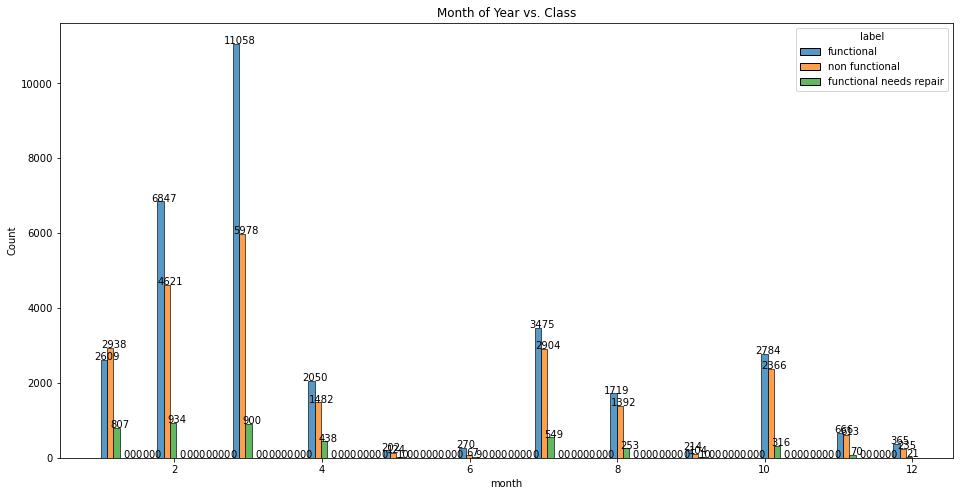

In [46]:
plt.figure(figsize=(16, 8))
ax=sns.histplot(data=data, x='month', hue='label', multiple='dodge')
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2)+.05, y=height+0.25, s=height, ha='center')
plt.title('Month of Year vs. Class')
plt.show()

There appears to be a some seasonality to when inspections are performed. This possibly coincides with wet and dry seasons in the region. Persons managing the wellpoints would typically have additional inspections before and during times of use to ensure limited down time during the peak demand. It would be expected that all types of wellpoints would have better water access during a wet season as groundwater levels rise, though we don't know how this becomes associated with demand as more non-wellpoint bodies of water are likely available at the same time. 

In [47]:
#Reviewing counts of labels per each month
monthcount = data.groupby(['label', 'month'])['id'].count().unstack()
monthcount

month,1,2,3,4,5,6,7,8,9,10,11,12
label,,,,,,,,,,,,
functional,2609,6847,11058,2050,202,270,3475,1719,214,2784,666,365
functional needs repair,807,934,900,438,10,9,549,253,10,316,70,21
non functional,2938,4621,5978,1482,124,67,2904,1392,104,2366,613,235


In [48]:
#Using our counts to determine percentges for simpler comparison against the total percentages found above
monthper = monthcount/monthcount.sum()*100
monthper

month,1,2,3,4,5,6,7,8,9,10,11,12
label,,,,,,,,,,,,
functional,41.060749,55.208837,61.652542,51.637280,60.119048,78.034682,50.158776,51.099881,65.243902,50.933041,49.369904,58.776167
functional needs repair,12.700661,7.531043,5.017841,11.032746,2.976190,2.601156,7.924365,7.520809,3.048780,5.781193,5.189029,3.381643
non functional,46.238590,37.260119,33.329616,37.329975,36.904762,19.364162,41.916859,41.379310,31.707317,43.285767,45.441067,37.842190


There does appear to be a difference month to month in level of functioning equipment. Let's take a look further at a single year

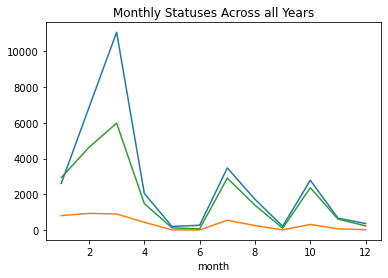

In [49]:
monthcount.loc['functional', :].plot()
monthcount.loc['functional needs repair', :].plot()
monthcount.loc['non functional', :].plot()
plt.title('Monthly Statuses Across all Years')
plt.show()

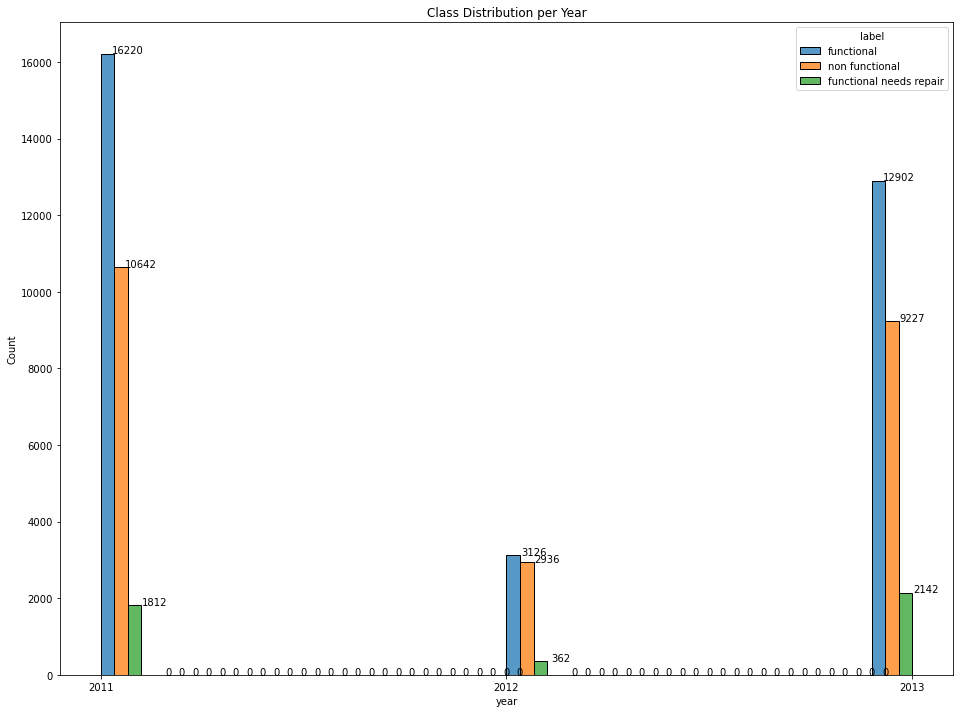

In [50]:
plt.figure(figsize=(16, 12))
ax=sns.histplot(data=data.loc[data['year']>2010], x='year', hue='label', multiple='dodge')
for p in ax.patches:
    height=p.get_height()
    ax.text(x=p.get_x()+(p.get_width()/2)+.05, y=height+0.25, s=height, ha='center')
plt.xticks([2011, 2012, 2013])
plt.title('Class Distribution per Year')
plt.show()

2011 and 2013 have simliar distributions of each class. 2012 appears to have a higher percentage of non functional class but we don't know if that was more a by product of the samller smaple size of inspections. Without knowing the reason for the considerable drop in inspections, we can't confidently say that there was a different distribution of classes.

In [51]:
#Reviewing counts of labels per each year
yearcount = data.groupby(['label', 'year'])['id'].count().unstack()
yearcount

year,2002,2004,2011,2012,2013
label,,,,,
functional,1.0,10.0,16220.0,3126.0,12902.0
functional needs repair,NaN,1.0,1812.0,362.0,2142.0
non functional,NaN,19.0,10642.0,2936.0,9227.0


In [52]:
#Using our counts to determine percentges for simpler comparison against the total percentages found above
yearper = yearcount/yearcount.sum()*100
yearper

year,2002,2004,2011,2012,2013
label,,,,,
functional,100.0,33.333333,56.566925,48.661270,53.158090
functional needs repair,NaN,3.333333,6.319314,5.635118,8.825347
non functional,NaN,63.333333,37.113762,45.703611,38.016563


We can drop a few additional columns that don't give value to our predictive power. wpt_name, num_private and recorded_by are all arbitrary informatio that we don't expect to gain insight from. They will be dropped.

In [53]:
data.drop(columns=['wpt_name', 'num_private', 'recorded_by'], inplace=True)

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     59400 non-null  int64         
 1   label                  59400 non-null  object        
 2   amount_tsh             59400 non-null  float64       
 3   date_recorded          59400 non-null  datetime64[ns]
 4   funder                 59400 non-null  object        
 5   gps_height             59400 non-null  int64         
 6   installer              59400 non-null  object        
 7   longitude              59400 non-null  float64       
 8   latitude               59400 non-null  float64       
 9   basin                  59400 non-null  object        
 10  subvillage             59400 non-null  object        
 11  region_code            59400 non-null  int64         
 12  district_code          59400 non-null  int64         
 13  w

In [55]:
data['amount_tsh'] = data['amount_tsh'].astype('int')
data['amount_tsh'].describe()

count     59400.00000
mean        317.65037
std        2997.57456
min           0.00000
25%           0.00000
50%           0.00000
75%          20.00000
max      350000.00000
Name: amount_tsh, dtype: float64

In [56]:
data['amount_tsh'].value_counts()

0         41643
500        3102
50         2472
1000       1488
20         1463
          ...  
170000        1
12            1
250000        1
9             1
70000         1
Name: amount_tsh, Length: 96, dtype: int64

In [57]:
data.loc[data['amount_tsh']>2000, 'amount_tsh'].value_counts().head(10)

5000     450
3000     334
4000     156
2400     145
2500     139
6000     125
8000      61
10000     57
12000     51
20000     45
Name: amount_tsh, dtype: int64

In [58]:
data['amount_tsh'].sort_values().tail(20)

47201     50000
51260     50000
53968     60000
21567     70000
38137    100000
6591     100000
3228     100000
10615    117000
54595    117000
44381    117000
37459    117000
5558     117000
45470    117000
57811    117000
9917     120000
9961     138000
45067    170000
22817    200000
22191    250000
10812    350000
Name: amount_tsh, dtype: int32

We are going to seperate this into bins to allow it function better with the classification algorithims. There also appears to be some issues with the top end values as 350,000 ft of head is more than 10x the height of Mt. Everest aka not possible for static head. We will use Standard Scaler on this column during feature engineering to ensure these high values don't cause the feature to be overweighted. We are also going to cap all values as 5000 and because more than two thirds of the column is at value zero, we will turn this into a categorical column of bins and eliminate the continuous column.

In [59]:
data.loc[data['amount_tsh']>5000, 'amount_tsh'] = 5000

In [60]:
data.loc[data['amount_tsh']>0, 'amount_tsh'] = pd.qcut(data.loc[data['amount_tsh']>0, 'amount_tsh'], q=5, duplicates='drop',labels=False)#, [-1, 1, 20.0, 30.0, 50.0, 100.0, 250, 500.0, 1000.0, 2200.0, 70000.0, 500000],
                         #labels=list(range(1,12)))
data['amount_tsh']

0        4
1        0
2        0
3        0
4        0
        ..
59395    0
59396    4
59397    0
59398    0
59399    0
Name: amount_tsh, Length: 59400, dtype: int64

In [61]:
data['amount_tsh']=data['amount_tsh'].astype('int')

Let's see visually if the ratio of functional to non functional seems to improve based on higher tsh

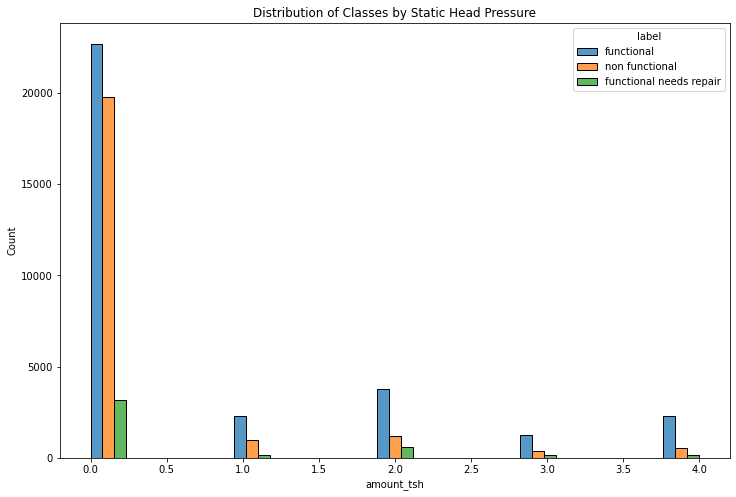

In [62]:
plt.figure(figsize=(12,8))
sns.histplot(data = data[['amount_tsh', 'label']], x='amount_tsh', hue='label', multiple='dodge')
plt.title('Distribution of Classes by Static Head Pressure')
plt.show()

Not suprisingly the more head available the higher the percentage of wellpoints are functional. This makes sense when you consider that higher head pressures would be able to more easily push through mechancial issues like lack of lubrication as well as dirt build up in piping. We assuming that these are common cause of non functional class.

We can set the the permit and public meeting columns to be 0 and 1 instead of True and False to make them easier for model ingestion

In [63]:
data['public_meeting'] = data['public_meeting'].map({True:1, False:0})

In [64]:
data['permit'] = data['permit'].map({True:1, False:0})

Let's take a look at the district code column and see if it differs greatly from the region_code column

In [65]:
data['district_code'].nunique(), data['district_code'].unique()

(20,
 array([ 5,  2,  4, 63,  1,  8,  3,  6, 43,  7, 23, 33, 53, 62, 60, 30, 13,
         0, 80, 67], dtype=int64))

In [66]:
data.loc[data['district_code']==data['region_code']]['region_code'].count()

3266

Based on there being limited times where the district_code is the same as the region_code and that we don't have a better definition for either variable, we will keep both

Let's continue by looking at construction_year and transforming it into a years old column

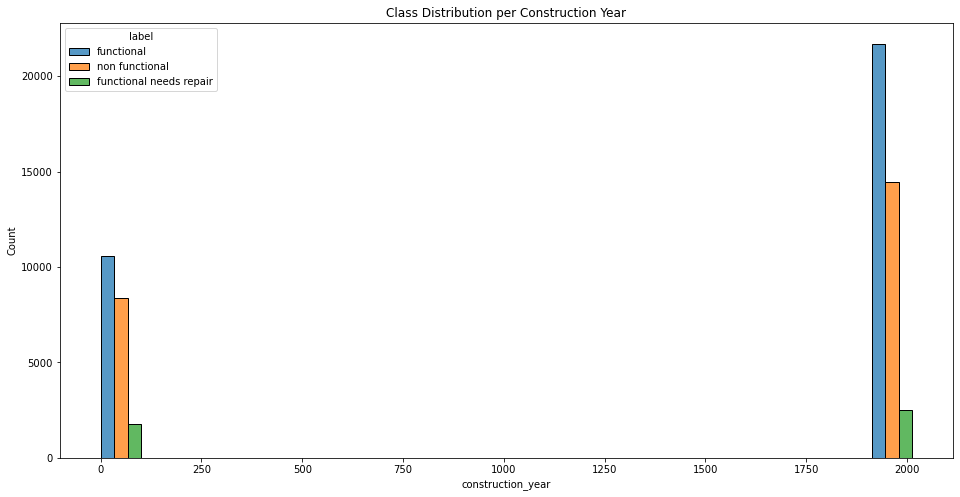

In [67]:
plt.figure(figsize=(16,8))
sns.histplot(data=data, x='construction_year', hue='label', multiple='dodge', bins=20)
plt.title('Class Distribution per Construction Year')
plt.show()

In [68]:
data['construction_year'].describe()

count    59400.000000
mean      1300.652475
std        951.620547
min          0.000000
25%          0.000000
50%       1986.000000
75%       2004.000000
max       2013.000000
Name: construction_year, dtype: float64

As it is a float and seems to have many zeros we will have to make some corrections

In [69]:
#lets look at how the data is spread out
data['construction_year'].value_counts()

0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: construction_year, dtype: int64

In [70]:
#looking just at the non zero data
data.loc[data['construction_year']>0,'construction_year'].describe()

count    38691.000000
mean      1996.814686
std         12.472045
min       1960.000000
25%       1987.000000
50%       2000.000000
75%       2008.000000
max       2013.000000
Name: construction_year, dtype: float64

We will use 1999 as a fill in date for the zeroes. This is based on the nonzero entries having a mean of ~1997 and a median of 2000. We will also convert it to a datetime object

In [71]:
data['construction_year'] = values['construction_year']

In [72]:
data['construction_year'].replace({0:1999}, inplace=True)
data['construction_year'] = pd.to_datetime(data['construction_year'], format='%Y')
data['construction_year']

0       1999-01-01
1       2010-01-01
2       2009-01-01
3       1986-01-01
4       1999-01-01
           ...    
59395   1999-01-01
59396   1996-01-01
59397   1999-01-01
59398   1999-01-01
59399   2002-01-01
Name: construction_year, Length: 59400, dtype: datetime64[ns]

In [73]:
data['years_old'] = data['date_recorded'].dt.year - data['construction_year'].dt.year
data['years_old']

0        12
1         3
2         4
3        27
4        12
         ..
59395    14
59396    15
59397    12
59398    12
59399     9
Name: years_old, Length: 59400, dtype: int64

Let's take a look at quality, quantity and waterpoint type. As with the previous source and extraction columns we are looking to limit collinearity without giving away data that is useful for prediction

In [74]:
data['water_quality'].value_counts(), data['quality_group'].value_counts()

(soft                  50818
 salty                  4856
 unknown                1876
 milky                   804
 coloured                490
 salty abandoned         339
 fluoride                200
 fluoride abandoned       17
 Name: water_quality, dtype: int64,
 good        50818
 salty        5195
 unknown      1876
 milky         804
 colored       490
 fluoride      217
 Name: quality_group, dtype: int64)

In [75]:
data['quantity'].value_counts(), data['quantity_group'].value_counts()

(enough          33186
 insufficient    15129
 dry              6246
 seasonal         4050
 unknown           789
 Name: quantity, dtype: int64,
 enough          33186
 insufficient    15129
 dry              6246
 seasonal         4050
 unknown           789
 Name: quantity_group, dtype: int64)

For quality, it would seem the only change from wateer quality to quality group is combining salty columns, fluoride columns and renaming soft to good. We will drop the quality group column. 

For quantity, there is diference between the columns so we will drop the quantity group column

In [76]:
data.drop(columns=['quality_group', 'quantity_group'], inplace=True)

In [77]:
data['waterpoint_type'].value_counts(), data['waterpoint_type_group'].value_counts()

(communal standpipe             28522
 hand pump                      17488
 other                           6380
 communal standpipe multiple     6103
 improved spring                  784
 cattle trough                    116
 dam                                7
 Name: waterpoint_type, dtype: int64,
 communal standpipe    34625
 hand pump             17488
 other                  6380
 improved spring         784
 cattle trough           116
 dam                       7
 Name: waterpoint_type_group, dtype: int64)

The only difference being the combination of communal standpipe columns in waterpoint type group. We will drop the waterpoint type group.

In [78]:
data.drop(columns=['waterpoint_type_group'],inplace=True)

Let's look into the management data. It is likely we will follow the same logic as with the subvillages where we keep the larger groups and part the smaller ones into bins.

In [79]:
data['scheme_management'].value_counts(), data['scheme_name'].value_counts()

(VWC                 36793
 WUG                  5206
 unknown              3877
 Water authority      3153
 WUA                  2883
 Water Board          2748
 Parastatal           1680
 Private operator     1063
 Company              1061
 Other                 766
 SWC                    97
 Trust                  72
 None                    1
 Name: scheme_management, dtype: int64,
 unknown                                     28166
 K                                             682
 None                                          644
 Borehole                                      546
 Chalinze wate                                 405
                                             ...  
 Pefa water supply                               1
 Gwanumpu Secondary  Pimping water supply        1
 Rodosi                                          1
 Government Borehole Scheme                      1
 Kurui water Supply                              1
 Name: scheme_name, Length: 2697, dtype: int64)

The two scheme columns have different enough infomration to keep both. The scheme management column with be left alone except for moving the 1 'None' value into the 'other' category. The scheme name column will need to have it's categories paired down.

In [80]:
data['scheme_name'].value_counts().head(20)

unknown                                  28166
K                                          682
None                                       644
Borehole                                   546
Chalinze wate                              405
M                                          400
DANIDA                                     379
Government                                 320
Ngana water supplied scheme                270
wanging'ombe water supply s                261
wanging'ombe supply scheme                 234
I                                          229
Bagamoyo wate                              229
Uroki-Bomang'ombe water sup                209
N                                          204
Kirua kahe gravity water supply trust      193
Machumba estate pipe line                  185
Makwale water supplied sche                166
Kijiji                                     161
S                                          154
Name: scheme_name, dtype: int64

In [81]:
counts2 = data['scheme_name'].value_counts()
counts2 = counts2.loc[counts2 >=200]
counts2 = list(counts2.index)
data.loc[~data['scheme_name'].isin(counts2), 'scheme_name'] = 'other'

In [82]:
data['scheme_name'].unique()

array(['other', 'unknown', 'None', "wanging'ombe water supply s",
       'Chalinze wate', 'Ngana water supplied scheme', 'K', 'M',
       "wanging'ombe supply scheme", 'Bagamoyo wate', 'N', 'Borehole',
       'DANIDA', 'Government', "Uroki-Bomang'ombe water sup", 'I'],
      dtype=object)

In [83]:
data['management'].value_counts(), data['management_group'].value_counts()

(vwc                 40507
 wug                  6515
 water board          2933
 wua                  2535
 private operator     1971
 parastatal           1768
 water authority       904
 other                 844
 company               685
 unknown               561
 other - school         99
 trust                  78
 Name: management, dtype: int64,
 user-group    52490
 commercial     3638
 parastatal     1768
 other           943
 unknown         561
 Name: management_group, dtype: int64)

We will keep both columns unchanged. Let's take a look into the installer and funder columns

In [84]:
data['funder'].value_counts(), data['installer'].value_counts()

(Government Of Tanzania    9084
 unknown                   3635
 Danida                    3114
 Hesawa                    2202
 Rwssp                     1374
                           ... 
 Nasan                        1
 Said Omari                   1
 Government /sda              1
 Asgerali N Bharwan           1
 Muivaru                      1
 Name: funder, Length: 1898, dtype: int64,
 DWE                  17402
 unknown               3656
 Government            1825
 RWE                   1206
 Commu                 1060
                      ...  
 WATER  AIDS              1
 Kalitesi                 1
 HESAWQ                   1
 Kiwanda cha Ngozi        1
 Mohamad Masanga          1
 Name: installer, Length: 2145, dtype: int64)

As with our previous categorical columns, there are a lot of categpories that have very small counts. We will compbine them into a single other category and keep the categories with larger counts seperated.

In [85]:
data['funder'].value_counts().head(50)

Government Of Tanzania            9084
unknown                           3635
Danida                            3114
Hesawa                            2202
Rwssp                             1374
World Bank                        1349
Kkkt                              1287
World Vision                      1246
Unicef                            1057
Tasaf                              877
District Council                   843
Dhv                                829
Private Individual                 826
Dwsp                               811
0                                  777
Norad                              765
Germany Republi                    610
Tcrs                               602
Ministry Of Water                  590
Water                              583
Dwe                                484
Netherlands                        470
Hifab                              450
Adb                                448
Lga                                442
Amref                    

As with our previous categorical columns, there are a lot of categpories that have relatively small counts. We will combine them into a single other category and keep the categories with larger counts seperated. The number for seperation is a guess for the time being and we can come back and adjust it if we find this to be an important feature to the model.

In [86]:
counts3 = data['funder'].value_counts()
counts3 = counts3.loc[counts3 >=500]
counts3 = list(counts3.index)
data.loc[~data['funder'].isin(counts3), 'funder'] = 'other'

In [87]:
data['funder'].unique()

array(['other', 'Unicef', 'Dwsp', 'Rwssp', 'Danida', 'World Vision',
       'Hesawa', 'Government Of Tanzania', 'Water', 'Private Individual',
       'unknown', 'District Council', 'Kkkt', 'Norad', 'Tcrs',
       'Germany Republi', 'Tasaf', 'World Bank', '0', 'Dhv',
       'Ministry Of Water'], dtype=object)

In [88]:
data['installer'].value_counts().head(20)

DWE                   17402
unknown                3656
Government             1825
RWE                    1206
Commu                  1060
DANIDA                 1050
KKKT                    898
Hesawa                  840
0                       777
TCRS                    707
Central government      622
CES                     610
Community               553
DANID                   552
District Council        551
HESAWA                  539
World vision            408
LGA                     408
WEDECO                  397
TASAF                   396
Name: installer, dtype: int64

As with our previous categorical columns, there are a lot of categpories that have relatively small counts. We will combine them into a single other category and keep the categories with larger counts seperated. The number for seperation is a guess for the time being and we can come back and adjust it if we find this to be an important feature to the model.

In [89]:
counts4 = data['installer'].value_counts()
counts4 = counts4.loc[counts4 >=500]
counts4 = list(counts4.index)
data.loc[~data['installer'].isin(counts4), 'installer'] = 'other'

In [90]:
data['installer'].unique()

array(['other', 'DWE', 'DANIDA', 'unknown', 'Central government', 'Commu',
       'Government', 'KKKT', 'RWE', 'HESAWA', 'Community', 'CES',
       'Hesawa', '0', 'DANID', 'TCRS', 'District Council'], dtype=object)

We are curiousto see if popultion plays a role in the distribution of classes. More population likely means more demand, but also could mean more resources in the area to fix problems more quickly and/or maintaint the wellpoint more frequently allowing for less issues leading the wellpoint being non functional

In [91]:
data['population'].describe()

count    59400.000000
mean       179.909983
std        471.482176
min          0.000000
25%          0.000000
50%         25.000000
75%        215.000000
max      30500.000000
Name: population, dtype: float64

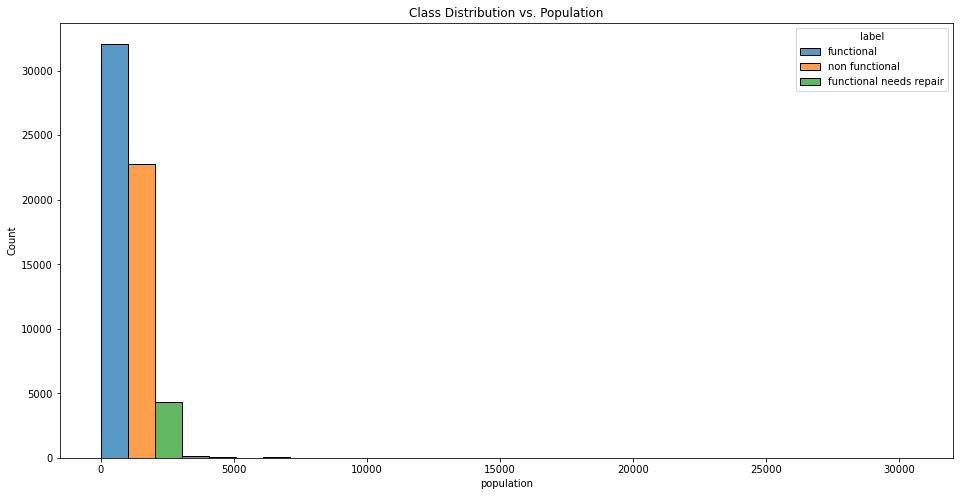

In [92]:
plt.figure(figsize=(16,8))
sns.histplot(data=data, x='population', hue='label', bins=10, multiple='dodge')
plt.title('Class Distribution vs. Population')
plt.show()

Due to the long right tail of the data it is difficult to see where the distribution of the lower end data whihc includes the majority of the data. We can look at only areas with populations between 2 and 2000. This will also eliminate the assumedly erroneaus entries of 0 and 1 for population from the visual.

In [93]:
data.loc[data['population'].between(2, 2000), 'population'].describe()

count    30512.000000
mean       287.557584
std        298.016438
min          2.000000
25%         96.000000
50%        200.000000
75%        360.000000
max       2000.000000
Name: population, dtype: float64

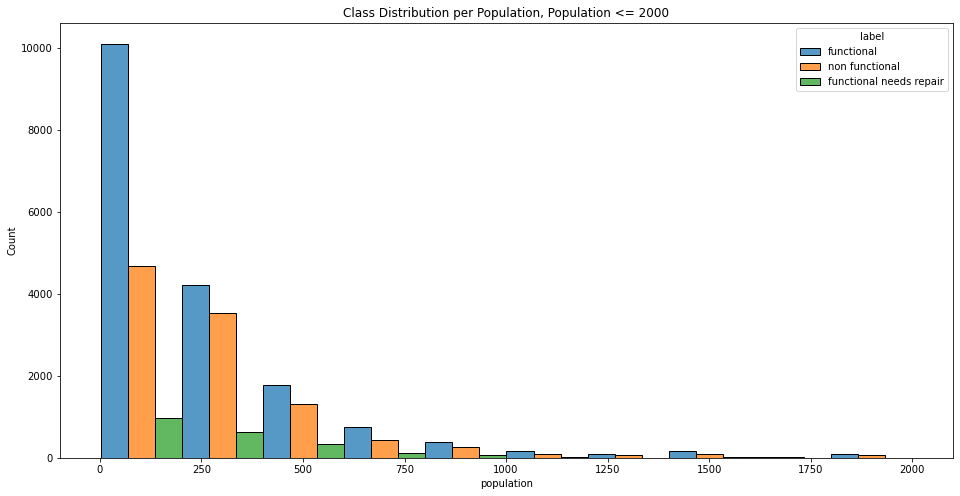

In [94]:
plt.figure(figsize=(16,8))
sns.histplot(data=data.loc[data['population'].between(2,2000)], x='population', hue='label', bins=10, multiple='dodge')
plt.title('Class Distribution per Population, Population <= 2000')
plt.show()

We will create a new bin column for population with additional bins at the lower end.

In [95]:
data['popbins'] = pd.cut(data['population'], [-1,2,250,500,1000,2500,10000,40000], labels=list(range(1,8)))

In [96]:
data['popbins']

0        2
1        3
2        2
3        2
4        1
        ..
59395    2
59396    2
59397    1
59398    1
59399    2
Name: popbins, Length: 59400, dtype: category
Categories (7, int64): [1 < 2 < 3 < 4 < 5 < 6 < 7]

Let's take a look at one of the final categorical features: ward. We can check if it matches up with the subvillage column in which case we will simply drop it to avoid colinearity. If not it is likely to be another column with many categories that will need to have categories with smaller counts combined.

In [97]:
data['ward'].value_counts()

Igosi        307
Imalinyi     252
Siha Kati    232
Mdandu       231
Nduruma      217
            ... 
Korongoni      1
Sungwisi       1
Ikweha         1
Mkumbi         1
Chinugulu      1
Name: ward, Length: 2092, dtype: int64

In [98]:
(data['ward']==data['subvillage']).sum()

1

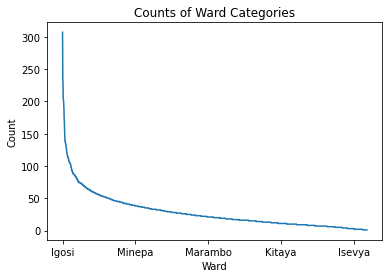

In [99]:
data['ward'].value_counts().plot()
plt.title('Counts of Ward Categories')
plt.xlabel('Ward')
plt.ylabel('Count')
plt.show()

We can break the wards in five categories: verybig, big, medium, small and verysmall. If we find these are important features for the model then we can also come back and expand on the amount of categories.

In [100]:
counts5 = data['ward'].value_counts()
verybig = counts5.loc[counts5.between(200,400)].index
big = counts5.loc[counts5.between(100,200)].index
medium = counts5.loc[counts5.between(50,100)].index
small = counts5.loc[counts5.between(25,50)].index
verysmall = counts5.loc[counts5 <=25].index
data.loc[data['ward'].isin(verybig), 'ward'] = 'verybig'
data.loc[data['ward'].isin(big), 'ward'] = 'big'
data.loc[data['ward'].isin(medium), 'ward'] = 'medium'
data.loc[data['ward'].isin(small), 'ward'] = 'small'
data.loc[data['ward'].isin(verysmall), 'ward'] = 'verysmall'

In [101]:
data['ward'].unique()

array(['small', 'medium', 'verysmall', 'verybig', 'big'], dtype=object)

Let's take a look at the latitude and longitude columns. It is possible we will see this ditribution line up well with population as we expect more wellpoints in populated areas, though we aren't sure what the calss trend for these areas is yet.

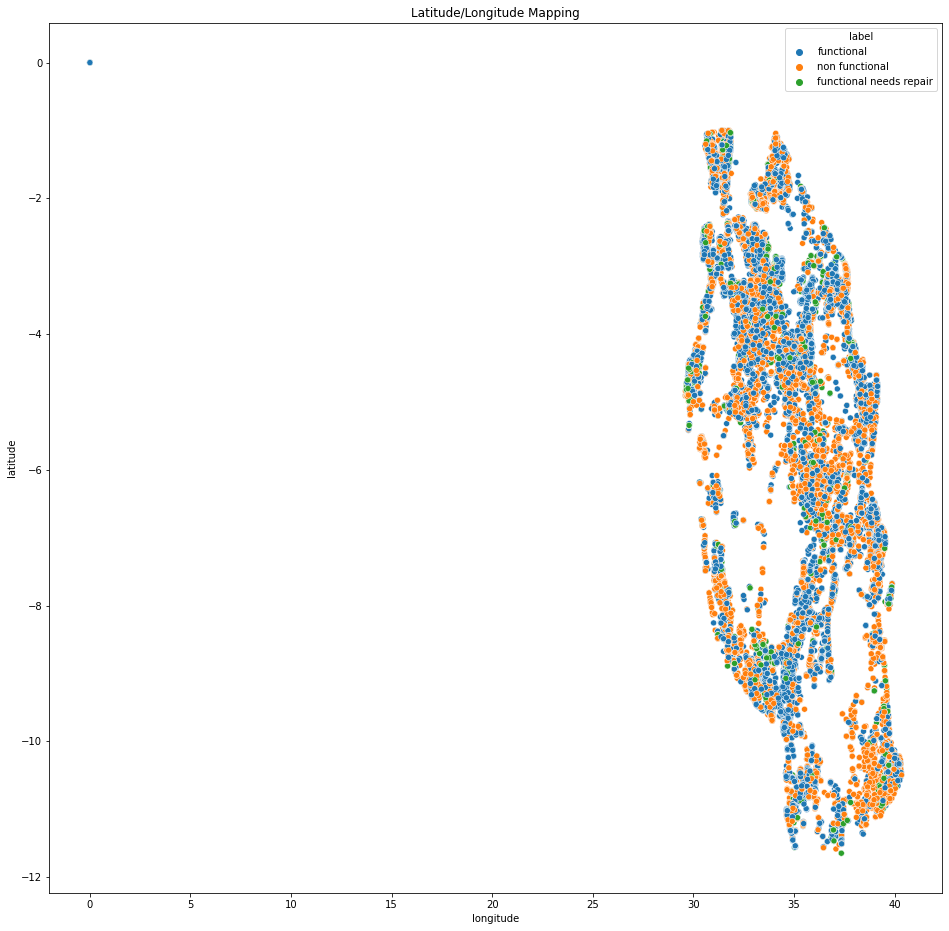

In [102]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=data, y='latitude', x='longitude', hue='label')
plt.title('Latitude/Longitude Mapping')
plt.show()

There is a few datapoints that seem to have incorrect values, lets take a look.

In [103]:
data['longitude'].describe()

count    59400.000000
mean        34.077427
std          6.567432
min          0.000000
25%         33.090347
50%         34.908743
75%         37.178387
max         40.345193
Name: longitude, dtype: float64

In [104]:
data.loc[data['longitude']==0]

,id,label,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,...,payment_type,water_quality,quantity,source,waterpoint_type,lga_Njombe,year,month,years_old,popbins
21,6091,functional,0,2013-02-10,Dwsp,0,DWE,0.0,-2.000000e-08,Lake Victoria,...,unknown,unknown,unknown,shallow_well,hand pump,0,2013,2,14,1
53,32376,non functional,0,2011-08-01,Government Of Tanzania,0,Government,0.0,-2.000000e-08,Lake Victoria,...,unknown,unknown,dry,machine_dbh,communal standpipe multiple,0,2011,8,12,1
168,72678,functional,0,2013-01-30,other,0,other,0.0,-2.000000e-08,Lake Victoria,...,other,soft,seasonal,rainwater_harvesting,communal standpipe,0,2013,1,14,1
177,56725,non functional,0,2013-01-17,other,0,DWE,0.0,-2.000000e-08,Lake Victoria,...,unknown,soft,enough,shallow_well,other,0,2013,1,14,1
253,13042,functional needs repair,0,2012-10-29,Hesawa,0,DWE,0.0,-2.000000e-08,Lake Victoria,...,never pay,soft,insufficient,shallow_well,hand pump,0,2012,10,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,functional needs repair,0,2011-07-18,Dwsp,0,DWE,0.0,-2.000000e-08,Lake Victoria,...,other,soft,enough,shallow_well,hand pump,0,2011,7,12,1
59208,3631,functional,0,2013-01-22,Dwsp,0,DWE,0.0,-2.000000e-08,Lake Victoria,...,unknown,soft,enough,shallow_well,hand pump,0,2013,1,14,1
59295,60843,functional needs repair,0,2011-07-19,Rwssp,0,DWE,0.0,-2.000000e-08,Lake Victoria,...,never pay,soft,enough,shallow_well,hand pump,0,2011,7,12,1
59324,748,functional,0,2013-01-22,World Vision,0,other,0.0,-2.000000e-08,Lake Victoria,...,unknown,soft,enough,shallow_well,hand pump,0,2013,1,14,1


The points all have the Lake Victoria basin. We will use an random value between the 25th and 75th percentiles from all datapoints in the Lake Victoria basin to fill in the zero values.

In [105]:
data.loc[data['basin']=='Lake Victoria']['longitude'].describe()

count    10248.000000
mean        27.284607
std         12.278315
min          0.000000
25%         30.864549
50%         32.686490
75%         33.584817
max         35.511809
Name: longitude, dtype: float64

In [106]:
data['longitude'] = data['longitude'].replace({0:np.random.choice(range(31,33))})

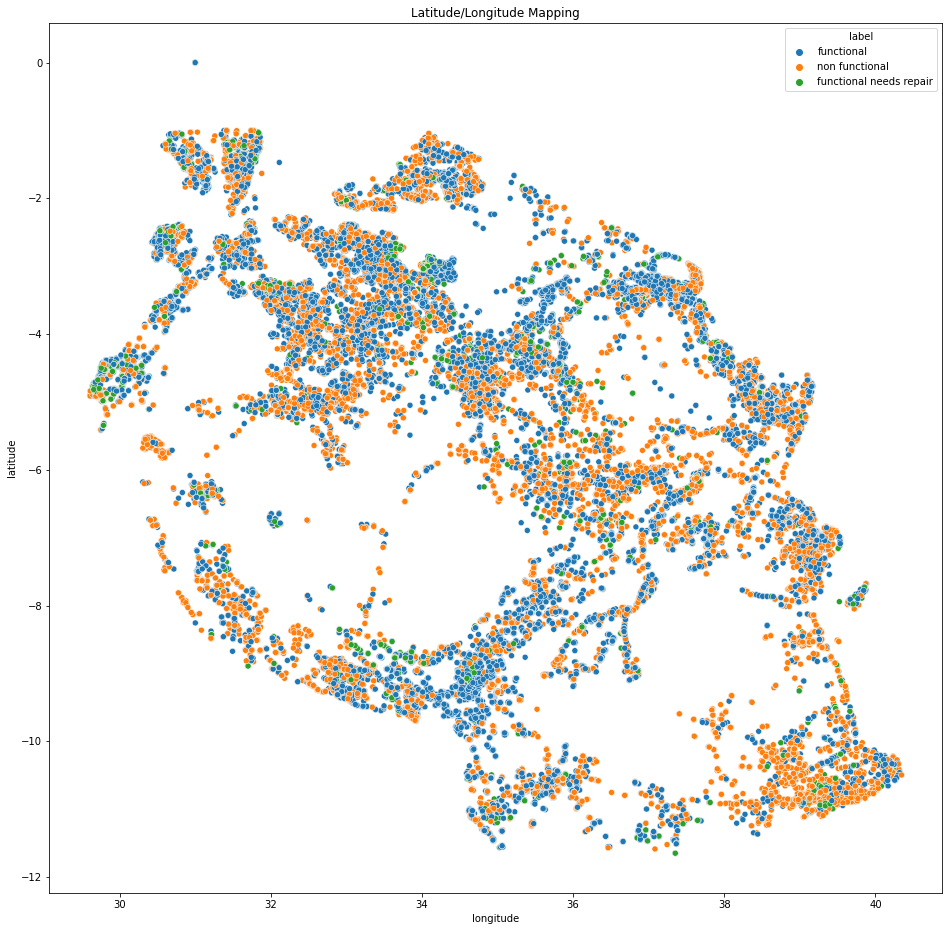

In [107]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=data, y='latitude', x='longitude', hue='label')
plt.title('Latitude/Longitude Mapping')
plt.show()

There is still an issue with a latitude value being zero, lets take a look

In [108]:
#Finding all columns with latitude == 0
data.loc[data['latitude']==0]

,id,label,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,...,payment_type,water_quality,quantity,source,waterpoint_type,lga_Njombe,year,month,years_old,popbins


In [109]:
#widening the search
data.loc[data['latitude']>-1]

,id,label,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,...,payment_type,water_quality,quantity,source,waterpoint_type,lga_Njombe,year,month,years_old,popbins
21,6091,functional,0,2013-02-10,Dwsp,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,unknown,unknown,unknown,shallow_well,hand pump,0,2013,2,14,1
53,32376,non functional,0,2011-08-01,Government Of Tanzania,0,Government,31.0,-2.000000e-08,Lake Victoria,...,unknown,unknown,dry,machine_dbh,communal standpipe multiple,0,2011,8,12,1
168,72678,functional,0,2013-01-30,other,0,other,31.0,-2.000000e-08,Lake Victoria,...,other,soft,seasonal,rainwater_harvesting,communal standpipe,0,2013,1,14,1
177,56725,non functional,0,2013-01-17,other,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,unknown,soft,enough,shallow_well,other,0,2013,1,14,1
253,13042,functional needs repair,0,2012-10-29,Hesawa,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,never pay,soft,insufficient,shallow_well,hand pump,0,2012,10,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,functional needs repair,0,2011-07-18,Dwsp,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,other,soft,enough,shallow_well,hand pump,0,2011,7,12,1
59208,3631,functional,0,2013-01-22,Dwsp,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,unknown,soft,enough,shallow_well,hand pump,0,2013,1,14,1
59295,60843,functional needs repair,0,2011-07-19,Rwssp,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,never pay,soft,enough,shallow_well,hand pump,0,2011,7,12,1
59324,748,functional,0,2013-01-22,World Vision,0,other,31.0,-2.000000e-08,Lake Victoria,...,unknown,soft,enough,shallow_well,hand pump,0,2013,1,14,1


In [110]:
#we can further tighen the search now that we see some of the issue values as -2.0E-08
data.loc[data['latitude']>-.01]

,id,label,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,basin,...,payment_type,water_quality,quantity,source,waterpoint_type,lga_Njombe,year,month,years_old,popbins
21,6091,functional,0,2013-02-10,Dwsp,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,unknown,unknown,unknown,shallow_well,hand pump,0,2013,2,14,1
53,32376,non functional,0,2011-08-01,Government Of Tanzania,0,Government,31.0,-2.000000e-08,Lake Victoria,...,unknown,unknown,dry,machine_dbh,communal standpipe multiple,0,2011,8,12,1
168,72678,functional,0,2013-01-30,other,0,other,31.0,-2.000000e-08,Lake Victoria,...,other,soft,seasonal,rainwater_harvesting,communal standpipe,0,2013,1,14,1
177,56725,non functional,0,2013-01-17,other,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,unknown,soft,enough,shallow_well,other,0,2013,1,14,1
253,13042,functional needs repair,0,2012-10-29,Hesawa,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,never pay,soft,insufficient,shallow_well,hand pump,0,2012,10,13,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59189,62177,functional needs repair,0,2011-07-18,Dwsp,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,other,soft,enough,shallow_well,hand pump,0,2011,7,12,1
59208,3631,functional,0,2013-01-22,Dwsp,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,unknown,soft,enough,shallow_well,hand pump,0,2013,1,14,1
59295,60843,functional needs repair,0,2011-07-19,Rwssp,0,DWE,31.0,-2.000000e-08,Lake Victoria,...,never pay,soft,enough,shallow_well,hand pump,0,2011,7,12,1
59324,748,functional,0,2013-01-22,World Vision,0,other,31.0,-2.000000e-08,Lake Victoria,...,unknown,soft,enough,shallow_well,hand pump,0,2013,1,14,1


Let's fill these values in a similar manner to the longitiude values using a random value between the 25th and 75th percentile of Lake Victoria basin datapoints.

In [111]:
data.loc[data['basin']=='Lake Victoria']['latitude'].describe()

count    1.024800e+04
mean    -1.866879e+00
std      1.047662e+00
min     -3.933140e+00
25%     -2.689709e+00
50%     -1.911210e+00
75%     -1.343601e+00
max     -2.000000e-08
Name: latitude, dtype: float64

In [112]:
data.loc[data['latitude']>-0.01, 'latitude'] = -1*np.random.choice(range(1,2))

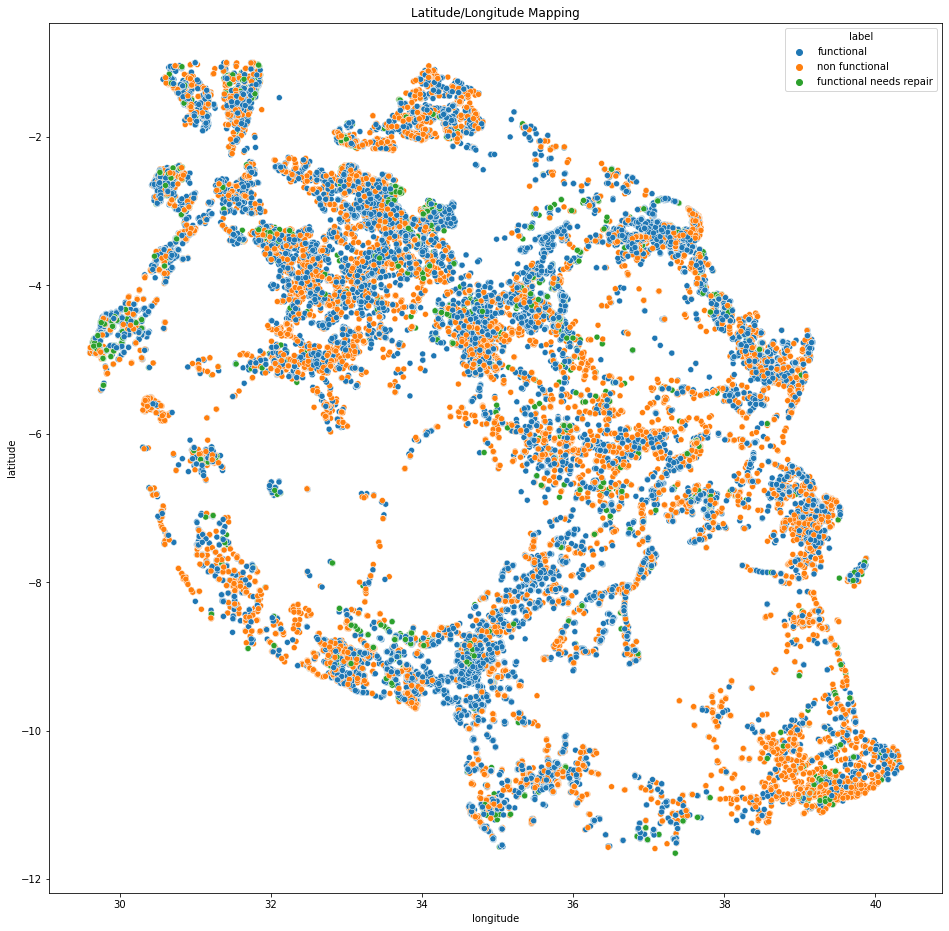

In [113]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=data, y='latitude', x='longitude', hue='label')
plt.title('Latitude/Longitude Mapping')
plt.show()

In [114]:
data['gps_height'].describe()

count    59400.000000
mean       668.297239
std        693.116350
min        -90.000000
25%          0.000000
50%        369.000000
75%       1319.250000
max       2770.000000
Name: gps_height, dtype: float64

In [115]:
data.loc[data['gps_height']>0, 'gps_height'].describe()

count    37466.000000
mean      1060.341803
std        587.707607
min          1.000000
25%        471.000000
50%       1194.000000
75%       1512.000000
max       2770.000000
Name: gps_height, dtype: float64

In [116]:
data.loc[data['gps_height']<1, 'gps_height'] = np.random.choice(range(471, 1512), 59400-37466)

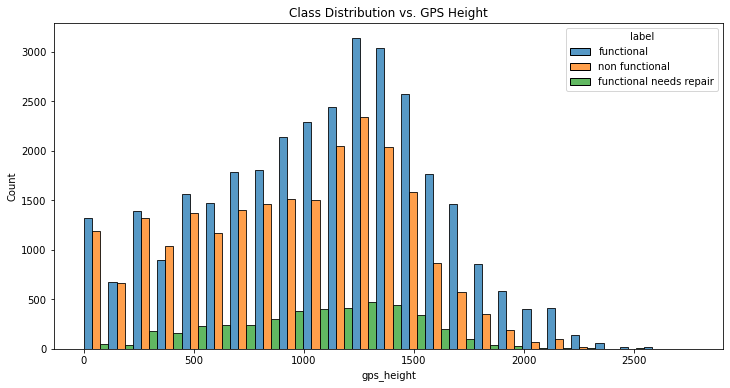

In [117]:
plt.figure(figsize=(12,6))
sns.histplot(data=data, x='gps_height', hue='label', multiple='dodge', bins=25)
plt.title('Class Distribution vs. GPS Height')
plt.show()

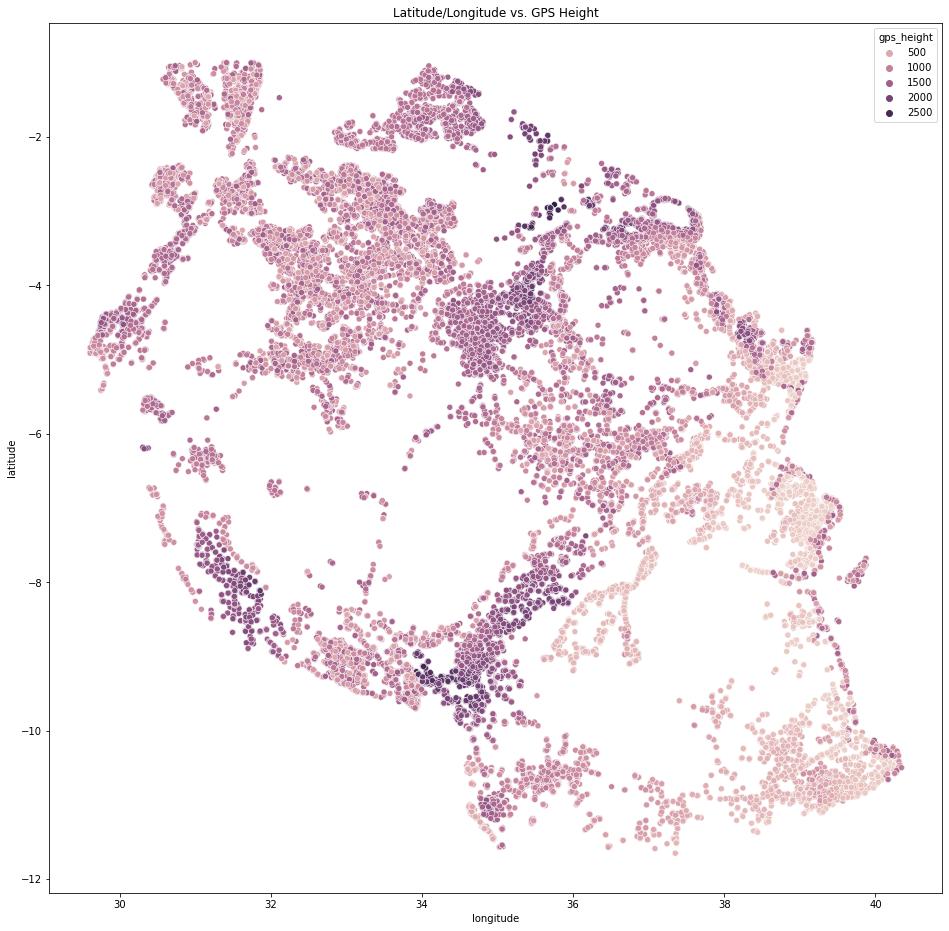

In [118]:
plt.figure(figsize=(16,16))
sns.scatterplot(data=data, y='latitude', x='longitude', hue='gps_height')
plt.title('Latitude/Longitude vs. GPS Height')
plt.show()

In [119]:
data.to_pickle('Data/train_values_EDA2.pkl')

While we have further EDA and cleaning that could be done we are going to move forward at this point to see how our model performs with what we currently have. We can always come back and ajust the number of bins for a category and or maxes and mins for continuos variables.